# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
# Based on: https://stackoverflow.com/a/17303428 (для красивого оформления результата z-теста)
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [4]:
RANDOM_SEED = 0

In [5]:
df = pd.read_csv('../datasets/tariff_recommendation_5ds.csv')

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Видим, что разрядность слишком высокая, оптимизируем типы данных.

In [8]:
float_features = df.select_dtypes(include='float64').columns
df[float_features] = df[float_features].apply(pd.to_numeric, downcast='float')
df['is_ultra'] = pd.to_numeric(df['is_ultra'], downcast='signed')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float32
 1   minutes   3214 non-null   float32
 2   messages  3214 non-null   float32
 3   mb_used   3214 non-null   float32
 4   is_ultra  3214 non-null   int8   
dtypes: float32(4), int8(1)
memory usage: 53.5 KB


In [10]:
df.sample(5, random_state=RANDOM_SEED)

,calls,minutes,messages,mb_used,is_ultra
2568,82.0,580.090027,96.0,21463.800781,0
2200,29.0,217.149994,46.0,16933.720703,0
306,36.0,250.880005,49.0,18965.019531,0
831,133.0,972.700012,83.0,38552.621094,0
2781,25.0,155.550003,98.0,17856.189453,0


In [11]:
pd.DataFrame(round((df.isna().mean()), 2)).style.background_gradient('coolwarm')\
                                                                .set_caption('% пропусков').format({0:'{:,.2%}'.format})

,0
calls,0.00%
minutes,0.00%
messages,0.00%
mb_used,0.00%
is_ultra,0.00%


### Выводы

- Данные состоят из 3214 строк и 5 столбцов: calls, minutes, messages, mb_used, is_ultra.
- Пропусков нет
- Данные по тарифам бьются в соотношении 70%/30% - 70% клиентов пользуются тарифом Smart, 30% клиентов тарифом Ultra
- Поскольку разрядность в данных высокая, мы оптимизировали типы данных.

## Разбейте данные на выборки

Построим диаграмму частот классов в целевом признаке.

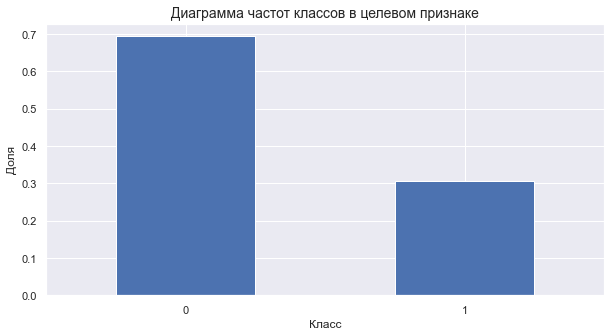

In [12]:
class_frequency = df['is_ultra'].value_counts(normalize=True)
plt.figure(figsize=(10, 5))
plt.title('Диаграмма частот классов в целевом признаке', size=14)
class_frequency.plot(kind='bar', rot=0)
plt.xlabel('Класс', size=12)
plt.ylabel('Доля', size=12)
plt.show()

В нашем датасете присутствует дисбаланс класов. Мы можем задать пропорцию классов при разделении на обучающий и проверяющий датасеты с помощью параметра `stratify` функции `train_test_split`. Стоит отметить, что мы будем стратифицировать в соответствии распределению по классам в столбце `is_ultra`, чтобы сохранить это соотношение.

Извлечем признаки и целевой признак.

In [13]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [14]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=RANDOM_SEED, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,
                                                                           random_state=RANDOM_SEED, stratify = target_valid)

***Проверка того, что выборки сформированы корректно.***

In [15]:
print('Train: ', features_train.shape, target_train.shape)
print('----------------')
print('Train: ', features_valid.shape, target_valid.shape)
print('----------------')
print('Train: ', features_test.shape, target_test.shape)


Train:  (1928, 4) (1928,)
----------------
Train:  (643, 4) (643,)
----------------
Train:  (643, 4) (643,)


### Выводы

- В исходных данных присутствует дисбаланс классов, поэтому мы задали пропорцию классов при разделении на на обучающую, валидационную и тестовую выборки
- Проверили, что данные разделены корректно - пропорция 3/1/1


## Исследуйте модели

Обучим модель случайного  леса и выберем лучшую по метрике accuracy.

Эти 2 цикла работают одинаковым образом - в первом случае мы не делали предсказания, а просто проверили Accuracy на обучающей и валидирующей выборках, во втором случае - мы делали предсказания, а затем рассчитывали Accuracy.

In [16]:
for depth in range(1, 11):
    model_dt = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth = depth) #обучение с заданной глубиной дерева
    model_dt.fit(features_train, target_train) #обучение модели
    result_train_dt = model_dt.score(features_train, target_train)
    result_valid_dt = model_dt.score(features_valid, target_valid) #качество модели
    print(color.UNDERLINE + "max_depth = " +  color.END, depth)
    print('Accuracy train: ', result_train_dt)
    print('Accuracy valid: ', result_valid_dt)

max_depth =  1
Accuracy train:  0.7557053941908713
Accuracy valid:  0.7418351477449455
max_depth =  2
Accuracy train:  0.7894190871369294
Accuracy valid:  0.7698289269051322
max_depth =  3
Accuracy train:  0.8003112033195021
Accuracy valid:  0.7838258164852255
max_depth =  4
Accuracy train:  0.8132780082987552
Accuracy valid:  0.7822706065318819
max_depth =  5
Accuracy train:  0.8174273858921162
Accuracy valid:  0.7822706065318819
max_depth =  6
Accuracy train:  0.8324688796680498
Accuracy valid:  0.7744945567651633
max_depth =  7
Accuracy train:  0.8464730290456431
Accuracy valid:  0.7776049766718507
max_depth =  8
Accuracy train:  0.8573651452282157
Accuracy valid:  0.7713841368584758
max_depth =  9
Accuracy train:  0.8692946058091287
Accuracy valid:  0.7807153965785381
max_depth =  10
Accuracy train:  0.8807053941908713
Accuracy valid:  0.76049766718507


In [17]:
for depth in range(1, 11):
    model_dt = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth = depth) #обучение с заданной глубиной дерева
    model_dt.fit(features_train, target_train) #обучение модели
    predictions_train_dt = model_dt.predict(features_train) #Предсказания
    predictions_valid_dt = model_dt.predict(features_valid) #Предсказания
    result_train_dt = accuracy_score(target_train, predictions_train_dt)
    result_valid_dt = accuracy_score(target_valid, predictions_valid_dt) #качество модели
    print(color.UNDERLINE + "max_depth = " +  color.END, depth)
    print('Accuracy train: ', result_train_dt)
    print('Accuracy valid: ', result_valid_dt)

max_depth =  1
Accuracy train:  0.7557053941908713
Accuracy valid:  0.7418351477449455
max_depth =  2
Accuracy train:  0.7894190871369294
Accuracy valid:  0.7698289269051322
max_depth =  3
Accuracy train:  0.8003112033195021
Accuracy valid:  0.7838258164852255
max_depth =  4
Accuracy train:  0.8132780082987552
Accuracy valid:  0.7822706065318819
max_depth =  5
Accuracy train:  0.8174273858921162
Accuracy valid:  0.7822706065318819
max_depth =  6
Accuracy train:  0.8324688796680498
Accuracy valid:  0.7744945567651633
max_depth =  7
Accuracy train:  0.8464730290456431
Accuracy valid:  0.7776049766718507
max_depth =  8
Accuracy train:  0.8573651452282157
Accuracy valid:  0.7713841368584758
max_depth =  9
Accuracy train:  0.8692946058091287
Accuracy valid:  0.7807153965785381
max_depth =  10
Accuracy train:  0.8807053941908713
Accuracy valid:  0.76049766718507


Нам больше всего подходит гиперпараметр `max_depth` =  5. В этом случае модель меньше всего переобучается Accuracy train =  0.82, Accuracy valid = 0.78

Обучим модель случайного леса и выберем наиболее подходящие гиперпараметры для нашей модели исходя из Accuracy. Сначала подберем `max_depth`, а затем `n_estimators`

In [18]:
for depth in range(1, 20):
    model_rf = RandomForestClassifier(random_state=RANDOM_SEED, max_depth=depth, n_estimators=20)
    model_rf.fit(features_train, target_train)
    result_train_rf = model_rf.score(features_train, target_train)
    result_valid_rf = model_rf.score(features_valid, target_valid)
    print(color.UNDERLINE + "max_depth = " +  color.END, depth)
    print('Accuracy train: ', result_train_rf)
    print('Accuracy valid: ', result_valid_rf)

max_depth =  1
Accuracy train:  0.7494813278008299
Accuracy valid:  0.7480559875583204
max_depth =  2
Accuracy train:  0.7878630705394191
Accuracy valid:  0.7729393468118196
max_depth =  3
Accuracy train:  0.8008298755186722
Accuracy valid:  0.7900466562986003
max_depth =  4
Accuracy train:  0.8117219917012448
Accuracy valid:  0.7962674961119751
max_depth =  5
Accuracy train:  0.8220954356846473
Accuracy valid:  0.7884914463452566
max_depth =  6
Accuracy train:  0.828838174273859
Accuracy valid:  0.7931570762052877
max_depth =  7
Accuracy train:  0.850103734439834
Accuracy valid:  0.7931570762052877
max_depth =  8
Accuracy train:  0.8635892116182573
Accuracy valid:  0.7947122861586314
max_depth =  9
Accuracy train:  0.879149377593361
Accuracy valid:  0.8040435458786936
max_depth =  10
Accuracy train:  0.8853734439834025
Accuracy valid:  0.7962674961119751
max_depth =  11
Accuracy train:  0.8978215767634855
Accuracy valid:  0.7900466562986003
max_depth =  12
Accuracy train:  0.907157676

Больше всего подходит модель случайного леса с  `max_depth` =  15:

    Accuracy train:  0.95
    Accuracy valid:  0.79

In [19]:
for est in range(10, 101, 10):
    model_rf = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=est, max_depth = 15)
    model_rf.fit(features_train, target_train)
    result_rf_train = model_rf.score(features_train, target_train)
    result_rf_valid = model_rf.score(features_valid, target_valid)
    print(color.UNDERLINE + "n_estimators = " +  color.END, est)
    print('Accuracy train: ', result_rf_train)
    print('Accuracy valid: ', result_rf_valid)

n_estimators =  10
Accuracy train:  0.9387966804979253
Accuracy valid:  0.7776049766718507
n_estimators =  20
Accuracy train:  0.946058091286307
Accuracy valid:  0.7947122861586314
n_estimators =  30
Accuracy train:  0.9507261410788381
Accuracy valid:  0.7869362363919129
n_estimators =  40
Accuracy train:  0.9517634854771784
Accuracy valid:  0.7853810264385692
n_estimators =  50
Accuracy train:  0.9507261410788381
Accuracy valid:  0.7791601866251944
n_estimators =  60
Accuracy train:  0.9512448132780082
Accuracy valid:  0.7822706065318819
n_estimators =  70
Accuracy train:  0.9528008298755186
Accuracy valid:  0.7838258164852255
n_estimators =  80
Accuracy train:  0.9522821576763485
Accuracy valid:  0.7838258164852255
n_estimators =  90
Accuracy train:  0.9522821576763485
Accuracy valid:  0.7853810264385692
n_estimators =  100
Accuracy train:  0.9528008298755186
Accuracy valid:  0.7838258164852255


Лучше всего по accuracy показала себя модель случайного леса с `n_estimators` = 20  и `max_depth` =  15:

    Accuracy train:  0.95
    Accuracy valid:  0.79

Обучим модель логистической регрессии.

In [20]:
model_lr = LogisticRegression(random_state=RANDOM_SEED)
model_lr.fit(features_train, target_train)
result_lr_train = model_lr.score(features_train, target_train)
result_lr_target = model_lr.score(features_valid, target_valid)

print("Accuracy train: ", result_lr_train)
print("Accuracy valid: ", result_lr_target)

Accuracy train:  0.7479253112033195
Accuracy valid:  0.76049766718507


Accuracy модели логистической регрессии на валидационной выборке:  0.76, а на тренировочной - 0.74. Она уступает по качеству модели случайного леса и дерева решений, но не переобучается в отличие от остальных.

### Выводы

**Дерево решений**

`max_depth` =  5. В этом случае модель меньше всего переобучается Accuracy train =  0.82, Accuracy valid = 0.78

**Случайный лес**

Лучше всего по accuracy показала себя модель случайного леса с `n_estimators` = 20  и `max_depth` =  15:

Accuracy train:  0.95, Accuracy valid:  0.79
        
**Логистическая регрессия**

Accuracy модели логистической регрессии на валидационной выборке: 0.76, а на тренировочной - 0.74. Она уступает по качеству модели случайного леса и дерева решений, но не переобучается в отличие от остальных.
    
***Лучше всего нам подходит модель случайного леса***


## Проверьте модель на тестовой выборке

In [21]:
model_rf = RandomForestClassifier(random_state=RANDOM_SEED, max_depth=15, n_estimators=20)
model_rf.fit(features_train, target_train)
predictions_test_rf = model_rf.predict(features_test) #Предсказания
result_rf = accuracy_score(target_test, predictions_test_rf) #качество модели
print("Accuracy на тестовой выборке: {:.10f}".format(result_rf))

Accuracy на тестовой выборке: 0.8071539658


На тестовой выборке модель случайного леса показала себя лучше, чем на валидационной. Accuracy = 0.81

### Вывод

Результаты модели случайного леса: Accuracy train: 0.95, Accuracy valid: 0.79, Accuracy test: 0.81

## (бонус) Проверьте модели на адекватность

Сравним получившуюся модель с константной.

In [22]:
df['is_ultra'].value_counts()/df.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

## Вывод

У константной модели Accuracy равно примерно 69%. Cоответственно если сравнивать с получившимся результатом логистической регрессии, где Accuracy равно 0.74 , можно сказать , что модель логистической регрессии предсказывает плохо и она нам не подходит. Со случайным лесом все более-менее: Accuracy на тесте = 0.81.

## Общий вывод

- Данные состоят из 3214 строк и 5 столбцов: calls, minutes, messages, mb_used, is_ultra.
- Пропусков нет
- Данные по тарифам бьются в соотношении 70%/30% - 70% клиентов пользуются тарифом Smart, 30% клиентов тарифом Ultra
- Поскольку разрядность в данных высокая, мы оптимизировали типы данных

- В исходных данных присутствует дисбаланс классов, поэтому мы задали пропорцию классов при разделении на на обучающую, валидационную и тестовую выборки
- Проверили, что данные разделены корректно - пропорция 3/1/1

**Дерево решений**

`max_depth` =  5. В этом случае модель меньше всего переобучается Accuracy train =  0.82, Accuracy valid = 0.78

**Случайный лес**

Лучше всего по accuracy показала себя модель случайного леса с `n_estimators` = 20  и `max_depth` =  15:

Accuracy train:  0.95, Accuracy valid:  0.79
        
**Логистическая регрессия**

Accuracy модели логистической регрессии на валидационной выборке: 0.76, а на тренировочной - 0.74. Она уступает по качеству модели случайного леса и дерева решений, но не переобучается в отличие от остальных.
    
***Лучше всего нам подходит модель случайного леса***

Результаты модели случайного леса: Accuracy train: 0.95, Accuracy valid: 0.79, Accuracy test: 0.81

У константной модели Accuracy равно примерно 69%. Cоответственно если сравнивать с получившимся результатом логистической регрессии, где Accuracy равно 0.74 , можно сказать , что модель логистической регрессии предсказывает плохо и она нам не подходит. Со случайным лесом все более-менее: Accuracy на тесте = 0.81.
